## Project 3: Fitting the Orbit of S2 to Measure the Mass of Sgr A*

**Team:** Eling Cheng and Allison Trusko  
**Course:** ASTRON 1221  
**Semester:** Fall 2025  
**Date:** 2025-12-04  
**GitHub Repository Link:** https://github.com/echengpython/Sgr-A-Stellar-Orbit---Black-Hole-Mass-Measurement-.git

### Goal:
The goal of this project is to fit a Keplerian orbit to the star S2 using published astrometric data, and from this fit determine the mass of the supermassive black hole at the center of the Milky Way. By modeling S2’s sky-plane motion and converting its angular orbit into physical units, the project computes an independent estimate of the black hole’s mass and visualizes the resulting orbital solution.

### Data and Tools:
- **NumPy**: array math and vectorized calculations  
- **Pandas**: loading and organizing the S2 astrometry table  
- **Matplotlib**: plotting the orbit and diagnostics  
- **SciPy (`scipy.optimize`)**: nonlinear fitting using `least_squares`  
- **Astropy (`astropy.time`)**: handling observation times and Julian years 
- **Astroquery**: retrieving published S2 astrometry data
- **Warnings module**: suppressing non-essential warnings 
- **S2 Astrometry Data**: extracts S2 astrometry data from Gillessen et al. (2009, ApJ 707, L114, Table 1) 


## Project Setup and Environment Initialization

In this cell, we begin by importing the essential Python packages required for our analysis and set up some fundamental constants used throughout the project. These imports and definitions form the foundation for handling, visualizing, and fitting the S2 star orbital data around the Galactic Center.

### Python Packages

- **NumPy (`np`)**: Provides high-performance numerical computing capabilities, including array operations and mathematical functions, which are critical for modeling the orbital mechanics of S2.  
- **Pandas (`pd`)**: Facilitates structured data handling with DataFrames, allowing us to efficiently store and manipulate the observational measurements of S2's positions over time.  
- **Matplotlib (`plt`)**: Used for creating publication-quality plots, which help visualize both the raw data and the fitted orbital model.  
- **SciPy (`least_squares`)**: Provides numerical optimization routines, which we use to fit the orbital parameters of S2 to the observed positions.  
- **Astropy (`Time`)**: Handles astronomical time conversions, enabling us to work consistently with observational epochs.  
- **Warnings**: Suppresses minor warnings that may arise during optimization or plotting, keeping the notebook output clean.

### Plot Settings

We update the Matplotlib plotting parameters to ensure that all figures are clear and legible. This includes setting a default figure size and font size suitable for scientific presentation.

### Fundamental Constants

To convert observational measurements into physical units, several constants are defined:

- `AU_PER_PC`: Number of astronomical units (AU) in a parsec, used for converting distances from angular measurements to physical separations.  
- `AU_IN_KM`: Length of one AU in kilometers, which is important for velocity and mass calculations.  
- `SEC_IN_YEAR`: Number of seconds in a Julian year, allowing time conversions from years to seconds.  
- `KM_S_PER_AU_PER_YEAR`: Conversion factor from AU/year to km/s, useful for translating orbital velocities.  
- `GMSUN_AU3_PER_YR2`: A simplified constant for Kepler's third law in units of AU, years, and solar masses. Using this factor allows us to directly relate the semi-major axis and period of the orbit to the mass of Sgr A* in solar masses.


By initializing these packages and constants, we ensure a consistent and precise computational environment for modeling S2’s orbit and ultimately estimating the mass of the supermassive black hole at the center of our galaxy.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    "figure.figsize": (8,6),
    "font.size": 12
})

# constants
AU_PER_PC = 206265.0           # AU in one parsec
AU_IN_KM = 1.495978707e8       # km
SEC_IN_YEAR = 31557600.0       # seconds (Julian year)
KM_S_PER_AU_PER_YEAR = AU_IN_KM / SEC_IN_YEAR  # conversion factor
GMSUN_AU3_PER_YR2 = 4 * (np.pi**2)  # in units such that M_sun = a_AU^3 / P_year^2 when using 2pi factor -> actually 4*pi^2
# Explanation: Kepler in units (AU, yr, M_sun): 4π^2 a^3 / (G * P^2) = GM ; Standard simplified relation:
# M(Msun) = a(AU)^3 / P(yr)^2  when constant chosen appropriately; using 4π^2 cancels if using angular frequency form.
print("Environment ready.")


Environment ready.


## Loading S2 Astrometry Data

Here we retrieve the observed positions of the star S2 from the Vizier catalog using `astroquery`. The data comes from **Gillessen et al. (2009, ApJ 707, L114, Table 1)** and includes:

- Observation year (`year`)
- Right Ascension offset (`x_mas`) and Declination offset (`y_mas`)
- Positional uncertainties (`x_err_mas`, `y_err_mas`)

We validate the data to ensure all required columns exist, assign default uncertainties if missing, and remove any invalid or non-finite entries. The positions are in **milliarcseconds**, which will later be converted to physical distances using the Galactic Center distance (`R₀ ≈ 8 kpc`). This cleaned and structured dataset provides the foundation for fitting S2's orbit and estimating the mass of Sgr A*.


In [2]:
# === Install astroquery if missing ===
try:
    from astroquery.vizier import Vizier
except ImportError:
    import subprocess
    import sys
    print("Installing astroquery in the current environment...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", "astroquery"], 
                         stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("✓ astroquery installed successfully!")
    print("⚠️  Please restart the kernel (Kernel → Restart) and run this cell again.")
    raise ImportError("Please restart the kernel after installation")

# === Fetch S2 astrometry from Vizier ===
# Note: numpy and pandas are already imported in Cell 2

def _validate_df_astrometry(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ["year", "x_mas", "y_mas"]:
        if c not in df.columns:
            raise ValueError(f"Required column '{c}' missing after VizieR mapping.")
    if "x_err_mas" not in df.columns:
        df["x_err_mas"] = 1.5
    if "y_err_mas" not in df.columns:
        df["y_err_mas"] = 1.5
    return df.sort_values("year").reset_index(drop=True)

df = None  # Initialize before loading data

try:
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    Vizier.columns = ["*"]

    # Gillessen+ 2009 ApJ 707 L114 table1: S2 astrometry
    cats = Vizier.get_catalogs("J/ApJ/707/L114/table1")
    if not cats:
        raise RuntimeError("No tables for J/ApJ/707/L114/table1")

    tab = cats[0].to_pandas()

    year_ast = pd.to_numeric(tab["Ep.A"], errors="coerce").values
    x_mas    = pd.to_numeric(tab["oRA"],  errors="coerce").values
    x_err    = pd.to_numeric(tab["e_oRA"], errors="coerce").values
    y_mas    = pd.to_numeric(tab["oDE"],  errors="coerce").values
    y_err    = pd.to_numeric(tab["e_oDE"], errors="coerce").values

    df = pd.DataFrame({
        "year": year_ast,
        "x_mas": x_mas,
        "y_mas": y_mas,
        "x_err_mas": x_err,
        "y_err_mas": y_err
    })
    df = df[np.isfinite(df["year"]) & np.isfinite(df["x_mas"]) & np.isfinite(df["y_mas"])].copy()
    df = _validate_df_astrometry(df)
    print(f"Loaded S2 astrometry (J/ApJ/707/L114/table1): {len(df)} rows.")
    print("Columns:", df.columns.tolist())

except ModuleNotFoundError as e:
    print(f"ERROR: Missing required module - {e}")
    print("Please install astroquery by running: pip install astroquery")
    print("Or install all requirements: pip install -r requirements.txt")
    df = None
except Exception as e:
    print(f"ERROR: Failed to load S2 astrometry from VizieR.")
    print(f"Error details: {e}")
    print("Please ensure:")
    print("  1. Internet connection is available")
    print("  2. astroquery is installed: pip install astroquery")
    df = None

# Display the first few rows (only if data was loaded successfully)
if 'df' in locals() and df is not None:
    try:
        from IPython.display import display
        display(df.head())
    except ImportError:
        print("\nFirst 5 rows:")
        print(df.head())
else:
    print("Data not loaded - cannot display dataframe.")


Loaded S2 astrometry (J/ApJ/707/L114/table1): 96 rows.
Columns: ['year', 'x_mas', 'y_mas', 'x_err_mas', 'y_err_mas']


,year,x_mas,y_mas,x_err_mas,y_err_mas
0,1992.224,-6.400000,172.000000,4.6,4.7
1,1994.314,-28.500000,179.000000,4.8,3.4
2,1995.439,-42.599998,164.100006,1.0,1.0
3,1995.534,-37.299999,172.100006,3.8,4.3
4,1996.253,-43.400002,164.399994,3.6,3.6


## Orbital Mechanics and Model Functions

This cell defines the core functions for modeling S2's orbit and computing derived quantities:

1. **`solve_kepler(M, e)`**:  
   Uses the Newton-Raphson method to solve **Kepler's equation** $( M = E - e \sin E )$ for the eccentric anomaly $(E)$, given the mean anomaly $(M)$ and eccentricity $(e)$.

2. **`orb_elements_to_sky(...)`**:  
   Converts classical orbital elements—semi-major axis, eccentricity, inclination, longitude of ascending node, argument of periapsis, orbital period, and time of pericenter passage—into **sky-plane positions** `(x, y)` in milliarcseconds.  
   - Applies the necessary **rotations** to project the orbit onto the plane of the sky.  
   - Includes optional **frame offsets and linear drifts** to account for reference frame differences.  
   - Returns the **true anomaly** for additional diagnostics.

3. **`radial_velocity_model(...)`**:  
   Computes the **radial velocity** of S2 in km/s from orbital elements and the Galactic Center distance $(R_0)$.  
   - Converts angular measurements to physical units (AU) using $(R_0)$.  
   - Calculates velocity using orbital geometry and Kepler's laws.  
   - Useful for comparing with spectroscopic measurements or checking orbital consistency.

These functions form the backbone of the orbital fitting procedure and allow us to predict both positions and velocities for given orbital parameters.


In [3]:
def solve_kepler(M, e, tol=1e-12, maxiter=200):
    M = np.array(M, dtype=float)
    E = M.copy()
    # Newton-Raphson
    for _ in range(maxiter):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = f / fp
        E -= dE
        if np.max(np.abs(dE)) < tol:
            break
    return E

def orb_elements_to_sky(t_years, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
                        x0_mas=0.0, y0_mas=0.0, vx0_masyr=0.0, vy0_masyr=0.0, tref_year=None):
    """
    Return sky-plane positions (x_mas, y_mas) including frame offset (x0,y0) and linear drift (vx0,vy0) about tref.
    """
    t = np.array(t_years, dtype=float)
    if tref_year is None:
        tref_year = np.mean(t)

    i = np.deg2rad(i_deg)
    Omega = np.deg2rad(Omega_deg)
    omega = np.deg2rad(omega_deg)

    M = 2*np.pi*(t - T0_year) / P_years
    E = solve_kepler(M, e)

    # orbital plane coords (mas)
    xprime = a_mas*(np.cos(E) - e)
    yprime = a_mas*np.sqrt(1-e*e)*np.sin(E)

    # rotate to sky
    cosO, sinO = np.cos(Omega), np.sin(Omega)
    cosw, sinw = np.cos(omega), np.sin(omega)
    cosi = np.cos(i)

    x_orb = xprime*(cosO*cosw - sinO*sinw*cosi) - yprime*(cosO*sinw + sinO*cosw*cosi)
    y_orb = xprime*(sinO*cosw + cosO*sinw*cosi) - yprime*(sinO*sinw - cosO*cosw*cosi)

    # add frame offset + drift
    dt = (t - tref_year)
    x = x_orb + x0_mas + vx0_masyr*dt
    y = y_orb + y0_mas + vy0_masyr*dt

    # true anomaly
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2.), np.sqrt(1-e)*np.cos(E/2.))
    return x, y, E, f


def radial_velocity_model(t_years, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms=0.0):
    """
    Compute radial velocity (km/s) of S2 for given orbital elements and distance R0_kpc.
    Derived from orbital geometry and Kepler's laws.
    - a_mas: angular semimajor axis (mas)
    - R0_kpc: distance to GC in kpc (free parameter)
    Returns v_rad_kms array.
    """
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)  # a_mas -> radians
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # mean motion (rad/yr)
    n = 2*np.pi / P_years
    # compute true anomaly f
    _, _, _, f = orb_elements_to_sky(t_years, a_mas, e, i_deg, 0.0, omega_deg, P_years, T0_year)
    i = np.deg2rad(i_deg)
    omega = np.deg2rad(omega_deg)
    # RV in AU/yr:
    v_AUyr = n * a_AU / np.sqrt(1 - e**2) * (np.cos(omega + f) + e*np.cos(omega)) * np.sin(i)
    # convert to km/s:
    v_kms = v_AUyr * KM_S_PER_AU_PER_YEAR
    return v_kms + V0_kms, a_AU  # return a_AU for diagnostics


## Residuals, Initial Guesses, and Parameter Bounds

This cell defines helper functions for fitting the S2 orbit by minimizing the difference between observed and modeled positions.

### `residuals_joint`

- Computes normalized residuals in **x** and **y** directions.  
- Accounts for both measurement uncertainties (`x_err`, `y_err`) and an additional scatter term (`s_xy`).  
- Optionally applies a **Gaussian prior** on the Galactic Center distance `R0_kpc` to guide the fit without fixing it.

### `_freeze_params_to_value`

- Utility function to fix a parameter to a specific value by setting its lower and upper bounds equal.  
- Useful for testing or partial fits.

### `build_initial_guess_and_bounds`

- Provides **initial guesses** for orbital parameters (semi-major axis, eccentricity, inclination, etc.) and `R0_kpc`.  
- Defines **lower and upper bounds** to ensure the optimizer searches within physically reasonable ranges.  
- Includes offsets (`x0`, `y0`) and linear drifts (`vx0`, `vy0`) for the reference frame.

### `_xy_model_only`

- Returns sky-plane positions `(x, y)` only, ignoring velocities and other outputs.  
- Helpful for plotting the model orbit without computing residuals.

These functions establish the framework for **least-squares fitting**, ensuring a stable and physically meaningful optimization process.


In [4]:
# === Residuals + guesses/bounds + helper ===

def residuals_joint(theta, t_ast, x_obs, y_obs, x_err, y_err, r0_prior=None):
    (a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
     R0_kpc, x0, y0, vx0, vy0, log_s_xy) = theta

    x_mod, y_mod, _, _ = orb_elements_to_sky(
        t_ast, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0, tref_year=None
    )

    s_xy = np.exp(log_s_xy)
    rx = (x_obs - x_mod) / np.sqrt(x_err**2 + s_xy**2)
    ry = (y_obs - y_mod) / np.sqrt(y_err**2 + s_xy**2)
    res = np.concatenate([rx, ry])

    # --- OPTIONAL GAUSSIAN PRIOR ON R0 (keeps R0 free but regularized) ---
    if r0_prior is not None:
        R0_mu, R0_sigma = r0_prior
        if R0_sigma > 0:
            res = np.concatenate([res, np.array([(R0_kpc - R0_mu)/R0_sigma])])

    return res

def _freeze_params_to_value(lower, upper, idx, value):
    lower[idx] = value
    upper[idx] = value

def build_initial_guess_and_bounds():
    # Start and bounds for R0 (free parameter with a prior)
    R0_init = 8.0   # fixed to 8.0 kpc (no RV data)
    R0_min  = 6.5
    R0_max  = 9.5

    theta0 = np.array([
        125.0, 0.88, 134.0, 226.0, 66.0, 15.9, 2002.33,  # orbit
        R0_init,                                         # 7: R0_kpc (free)
        0.0, 0.0, 0.0, 0.0,                              # 8..11: x0,y0,vx0,vy0
        np.log(0.1)                                      # 12: log_s_xy (mas) - lower for better fit
    ])

    lower = np.array([
         80.0, 0.5,   0.0,   0.0,   0.0, 10.0, 2001.0,
         R0_min,
        -10.0, -10.0, -2.0, -2.0,
        np.log(0.05)
    ])
    upper = np.array([
        200.0, 0.99, 180.0, 360.0, 360.0, 25.0, 2004.0,
        R0_max,
         10.0,  10.0,  2.0,  2.0,
        np.log(2.0)
    ])
    return theta0, lower, upper

def _xy_model_only(years, p):
    x, y, *_ = orb_elements_to_sky(
        years, p[0], p[1], p[2], p[3], p[4], p[5], p[6],
        x0_mas=p[8], y0_mas=p[9], vx0_masyr=p[10], vy0_masyr=p[11]
    )
    return x, y



## Joint Astrometry and Radial Velocity Fitting

This function performs a **combined fit** of S2's astrometric positions and optional radial velocity measurements using `scipy.optimize.least_squares`.

### Key Features:

- Extracts observational arrays from the DataFrame, including uncertainties in x, y, and optionally radial velocity (`rv_kms`).  
- Uses the previously defined **initial guesses and bounds** to guide the optimizer.  
- Calls `residuals_joint` to compute the normalized residuals for least-squares fitting.  
- Supports robust fitting with different loss functions (default `'huber'`) to reduce sensitivity to outliers.  
- Estimates the **covariance matrix** and **parameter uncertainties** from the Jacobian of the fit, providing confidence intervals for each orbital parameter.  
- Returns a dictionary containing fitted parameters (`popt`), uncertainties (`perr`), covariance (`cov`), and the full `least_squares` result for diagnostics.

This function centralizes the fitting pipeline for both position and velocity data.


In [5]:
def fit_joint_astrometry_rv(df, rv_column='rv_kms', rv_err_column='rv_err_kms', rv_weights=1.0, loss='huber'):
    """
    df: DataFrame with columns year, x_mas, y_mas, x_err_mas, y_err_mas, optionally rv_kms, rv_err_kms
    Returns: result dict with popt, perr, cov, res (least_squares result)
    """
    # astrometry arrays
    t_ast = df['year'].values
    x_obs = df['x_mas'].values
    y_obs = df['y_mas'].values
    x_err = df.get('x_err_mas', pd.Series(np.ones_like(x_obs)*1.5)).values
    y_err = df.get('y_err_mas', pd.Series(np.ones_like(y_obs)*1.5)).values

    # radial velocities (if present)
    if (rv_column in df.columns) and (rv_err_column in df.columns):
        t_rv = df['year'].values
        rv_obs = df[rv_column].values
        rv_err = df[rv_err_column].values
        rv_mask = np.isfinite(rv_obs) & np.isfinite(rv_err)
    else:
        t_rv, rv_obs, rv_err, rv_mask = None, None, None, None

    theta0, lower, upper = build_initial_guess_and_bounds()
    print("Initial guess (theta0):", theta0)
    print("Bounds lower:", lower)
    print("Bounds upper:", upper)
    res = least_squares(residuals_joint, theta0, args=(t_ast, x_obs, y_obs, x_err, y_err, t_rv, rv_obs, rv_err, rv_mask, rv_weights),
                        bounds=(lower, upper), loss=loss, max_nfev=50000)
    popt = res.x
    # covariance estimate: inv(J^T J) * s^2
    try:
        J = res.jac
        JTJ = J.T.dot(J)
        dof = (2*len(t_ast) + (np.sum(rv_mask) if rv_mask is not None else 0)) - len(popt)
        s2 = np.sum(res.fun**2) / max(1, dof)
        cov = np.linalg.inv(JTJ) * s2
        perr = np.sqrt(np.abs(np.diag(cov)))
    except Exception as e:
        print("Covariance estimation failed:", e)
        cov = None
        perr = None
    return dict(popt=popt, perr=perr, cov=cov, res=res)


## Astrometry-Only Fitting and Covariance Estimation

This cell defines functions to perform **refined orbital fits** using astrometric data alone.

### `fit_joint_astrometry_rv` (modified for astrometry-only)
- Performs a **two-pass least-squares fit** to ensure accurate convergence.  
- First pass uses tight tolerances for stability; second pass refines the solution.  
- Computes the **covariance matrix** and parameter uncertainties from the Jacobian for error estimation.  
- Provides detailed printouts for optimization status, cost, and convergence diagnostics.

### `fit_astrometry_only`
- Simplified wrapper for astrometry-only fitting, optionally including a **Gaussian prior on R0**.  
- Uses the same two-pass approach to improve the fit quality.  

### `_cov_from_svd`
- Alternative covariance estimator using **singular value decomposition (SVD)** for robust error estimation, especially when the Jacobian is nearly singular.

These functions centralize the fitting workflow and ensure **stable, physically meaningful orbital solutions**.


In [6]:
def fit_joint_astrometry_rv(df, rv_column=None, rv_err_column=None, rv_weights=1.0, loss='huber'):
    """
    Kept function name for compatibility, but now it's astrometry-only.
    """
    t_ast = df['year'].values
    x_obs = df['x_mas'].values
    y_obs = df['y_mas'].values
    x_err = df.get('x_err_mas', pd.Series(np.ones_like(x_obs)*1.5)).values
    y_err = df.get('y_err_mas', pd.Series(np.ones_like(y_obs)*1.5)).values

    theta0, lower, upper = build_initial_guess_and_bounds()
    print("Initial guess (theta0):", theta0)
    print("Bounds lower:", lower)
    print("Bounds upper:", upper)

    # First pass: use tighter tolerances for better convergence
    res = least_squares(
        residuals_joint, theta0,
        args=(t_ast, x_obs, y_obs, x_err, y_err),
        bounds=(lower, upper), loss='linear', max_nfev=100000,
        ftol=1e-9, xtol=1e-9, gtol=1e-9, method='trf'
    )
    
    # Refine with the result as new starting point
    if res.success:
        print(f"First pass successful. Cost: {np.sum(res.fun**2):.4f}")
        # Second pass: refine from current best fit with even tighter tolerances
        res2 = least_squares(
            residuals_joint, res.x,
            args=(t_ast, x_obs, y_obs, x_err, y_err),
            bounds=(lower, upper), loss='linear', max_nfev=50000,
            ftol=1e-10, xtol=1e-10, gtol=1e-10, method='trf'
        )
        if res2.success and np.sum(res2.fun**2) < np.sum(res.fun**2):
            print(f"Refinement improved cost to: {np.sum(res2.fun**2):.4f}")
            res = res2
    else:
        print(f"Warning: Optimization did not fully converge. Status: {res.status}")
    
    print(f"Final optimization status: {res.status}, message: {res.message}")
    print(f"Final cost: {np.sum(res.fun**2):.4f}")
    popt = res.x

    # Covariance estimate: inv(J^T J) * s^2
    try:
        J = res.jac
        JTJ = J.T.dot(J)
        dof = (2*len(t_ast)) - len(popt)
        s2 = np.sum(res.fun**2) / max(1, dof)
        cov = np.linalg.inv(JTJ) * s2
        perr = np.sqrt(np.abs(np.diag(cov)))
    except Exception as e:
        print("Covariance estimation failed:", e)
        cov = None
        perr = None
    return dict(popt=popt, perr=perr, cov=cov, res=res)

# ---------- Astrometry-only fit ----------
def fit_astrometry_only(df, loss='linear', r0_prior=None):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    theta0, lower, upper = build_initial_guess_and_bounds()

    # First pass: use tighter tolerances for better convergence
    res = least_squares(
        residuals_joint, theta0,
        args=(t, x, y, xerr, yerr, r0_prior),  # <-- prior flows into residuals
        bounds=(lower, upper), loss=loss, max_nfev=100000,
        ftol=1e-9, xtol=1e-9, gtol=1e-9, method='trf'
    )
    
    # Refine with the result as new starting point
    if res.success:
        print(f"First pass successful. Cost: {np.sum(res.fun**2):.4f}")
        # Second pass: refine from current best fit with even tighter tolerances
        res2 = least_squares(
            residuals_joint, res.x,
            args=(t, x, y, xerr, yerr, r0_prior),
            bounds=(lower, upper), loss=loss, max_nfev=50000,
            ftol=1e-10, xtol=1e-10, gtol=1e-10, method='trf'
        )
        if res2.success and np.sum(res2.fun**2) < np.sum(res.fun**2):
            print(f"Refinement improved cost to: {np.sum(res2.fun**2):.4f}")
            res = res2
    else:
        print(f"Warning: Optimization did not fully converge. Status: {res.status}")
    
    print(f"Final optimization status: {res.status}, message: {res.message}")
    print(f"Final cost: {np.sum(res.fun**2):.4f}")
    
    return res


def _cov_from_svd(res, dof, rcond=1e-12):
    J = res.jac
    U, s, Vt = np.linalg.svd(J, full_matrices=False)
    s2 = np.sum(res.fun**2) / max(1, dof)
    tol = rcond * s.max() if s.size else 0.0
    w = np.zeros_like(s)
    mask = s > tol
    w[mask] = 1.0 / (s[mask]**2)
    cov = (Vt.T * w) @ Vt * s2
    return cov


## Fit Summary and Goodness-of-Fit

The `summarize_fit` function evaluates the **quality of the orbital fit** and estimates parameter uncertainties.

### Key Steps:

- Computes the model positions `(xmod, ymod)` from the fitted parameters.  
- Calculates **chi-squared** and **reduced chi-squared** to assess goodness-of-fit, accounting for measurement errors and extra scatter (`s_xy`).  
- Reports the total chi-squared, degrees of freedom, and reduced chi-squared for quick diagnostics.  
- Estimates the **covariance matrix** via **singular value decomposition (SVD)**, providing uncertainties and correlations between fitted parameters.  
- Returns the covariance matrix for further error propagation and plotting confidence intervals.

This function provides a **concise quantitative summary** of how well the orbital model matches the data.


In [7]:
def summarize_fit(df, res, label="astrometry-only"):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    theta = res.x
    (a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
     R0_kpc, x0, y0, vx0, vy0, log_s_xy) = theta
    s_xy = np.exp(log_s_xy)

    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0, y0, vx0, vy0
    )

    chi2_ast = np.sum(((x - xmod)/np.sqrt(xerr**2 + s_xy**2))**2
                      + ((y - ymod)/np.sqrt(yerr**2 + s_xy**2))**2)
    N_ast = 2*len(t)
    N_params = len(theta)
    dof = N_ast - N_params
    red = chi2_ast / max(dof, 1)

    print(f"[{label}] chi2_total={chi2_ast:.2f}  dof={dof}  reduced_chi2={red:.3f}")

    # Covariance via SVD
    try:
        J = res.jac
        U, S, Vt = np.linalg.svd(J, full_matrices=False)
        s2 = chi2_ast / max(dof, 1)
        cov = (Vt.T * (s2 / (S**2))) @ Vt
    except Exception:
        cov = None

    return cov

In [8]:
def eval_linear_at_solution(df, popt):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    # Freeze all params at popt
    lower = popt.copy()
    upper = popt.copy()
    for i in range(len(popt)):
        _freeze_params_to_value(lower, upper, i, popt[i])

    res_lin = least_squares(
        residuals_joint, popt,
        args=(t, x, y, xerr, yerr),
        bounds=(lower, upper), loss='linear', max_nfev=1
    )

    r = res_lin.fun
    chi2 = np.sum(r**2)
    N_params = len(popt)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[linear eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return res_lin, chi2, red

def eval_chi2_no_jitter(df, popt):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    th = popt.copy()
    i_sxy = 12
    near_zero_log = np.log(1e-12)
    th[i_sxy] = near_zero_log

    lower = th.copy(); upper = th.copy()
    for i in range(len(th)):
        _freeze_params_to_value(lower, upper, i, th[i])

    res_lin = least_squares(
        residuals_joint, th,
        args=(t, x, y, xerr, yerr),
        bounds=(lower, upper), loss='linear', max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(th)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[no-jitter eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return chi2, red


## Running the Orbital Fits and Evaluating Results

In this section, we perform the **astrometry-only fit** with a **soft prior on the Galactic Center distance** (`R0 = 8.0 ± 0.2 kpc`) to stabilize the solution.  

### Steps:

1. **Fit execution**  
   - We use `fit_astrometry_only` with the Huber loss function, which is robust against outliers in the S2 astrometry measurements.  
   - The soft prior on `R0` keeps the distance physically reasonable while allowing the optimizer to adjust it.  

2. **Post-fit summary**  
   - `summarize_fit` computes the **chi-squared**, **reduced chi-squared**, and covariance matrix to quantify fit quality and parameter uncertainties.  

3. **Diagnostics without bounds or jitter**  
   - `eval_linear_at_solution` evaluates the residuals and chi-squared using linear weighting.  
   - `eval_chi2_no_jitter` recalculates chi-squared assuming negligible extra scatter (`s_xy → 0`), providing a stricter assessment of fit quality.  

These steps ensure we have a robust, well-characterized solution for S2’s orbital parameters and their uncertainties.


In [9]:
# ================== RUN FITS + REPORT ==================
# Evaluation helpers 

def eval_linear_at_solution(df, popt):
    import numpy as np
    from scipy.optimize import least_squares

    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    # Evaluate residuals/Jacobian at popt with NO bounds
    res_lin = least_squares(
        residuals_joint, popt,
        args=(t, x, y, xerr, yerr, None),   # r0_prior=None for evaluation only
        bounds=(-np.inf, np.inf),
        loss='linear',
        max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(popt)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[linear eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return res_lin, chi2, red


def eval_chi2_no_jitter(df, popt):
    import numpy as np
    from scipy.optimize import least_squares

    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    th = popt.copy()
    i_sxy = 12   # log_s_xy index in the astrometry-only model
    th[i_sxy] = np.log(1e-12)  # effectively zero jitter

    # Evaluate at th with NO bounds
    res_lin = least_squares(
        residuals_joint, th,
        args=(t, x, y, xerr, yerr, None),   # r0_prior=None for evaluation only
        bounds=(-np.inf, np.inf),
        loss='linear',
        max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(th)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[no-jitter eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return chi2, red



# ================== FIT WITH R0 PRIOR (Choice A) ==================
# Literature-like weak prior; tweak sigma to be looser/tighter
R0_PRIOR = (8.0, 0.20)   # mean 8.0 kpc, sigma 0.20 kpc (tighter prior)

resA = fit_astrometry_only(df, loss='huber', r0_prior=R0_PRIOR)
covA = summarize_fit(df, resA, label="astrometry-only (WITH R0 prior)")

# Post-fit diagnostics (evaluate the solution; no prior needed for these eval calls)
popt = resA.x
_ = eval_linear_at_solution(df, popt)
_ = eval_chi2_no_jitter(df, popt)

# Keep covariance for mass uncertainty calculation
cov = covA


First pass successful. Cost: 215.5341
Final optimization status: 2, message: `ftol` termination condition is satisfied.
Final cost: 215.5341
[astrometry-only (WITH R0 prior)] chi2_total=215.53  dof=179  reduced_chi2=1.204
[linear eval] chi2=215.53, dof=179, reduced chi2=1.204
[no-jitter eval] chi2=1295.73, dof=179, reduced chi2=7.239


## Calculating the Black Hole Mass from the Fitted Orbit

Once the orbital parameters of S2 are determined, we can infer the **mass of Sgr A*** using Kepler's Third Law. The semi-major axis `a` (in milliarcseconds) is converted to physical units (AU) using the fitted Galactic Center distance `R0`. The mass is then computed as:

$M = \frac{a_{\rm AU}^3}{P^2} \quad [M_\odot]$

where \(P\) is the orbital period in years.  

### Fitted values

- **Semi-major axis:** $(a = {popt[0]:.4f}\,\mathrm{mas} \approx {aAU:.2f}\,\mathrm{AU}) $ 
- **Orbital period:** $P = (popt[5]:.5f)\,\mathrm{yr}$
- **Inferred central mass:** $(M = {Mfit/1e6:.4f} \times 10^6 M_\odot \approx {Mfit:.0f} M_\odot) $ 

### Uncertainty propagation

Using the covariance matrix from the fit, we propagate uncertainties in `a`, `P`, and `R0` to estimate the 1σ uncertainty on the mass. Fractional contributions highlight which parameter dominates the error budget (typically `a` and `R0`).  

This step quantifies both the **precision** and **robustness** of the inferred supermassive black hole mass at the center of the Milky Way.


In [10]:
def mass_from_fitted(popt):
    # popt: [a_mas,e,i_deg,Omega,omega,P,T0,R0_kpc,V0]
    a_mas = popt[0]
    P = popt[5]
    R0_kpc = popt[7]
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # Kepler: M (Msun) = a_AU^3 / P_years^2
    M = a_AU**3 / (P**2)
    return M, a_AU

Mfit, aAU = mass_from_fitted(popt)
print(f"Fitted semi-major axis = {popt[0]:.4f} mas -> {aAU:.2f} AU (using R0={popt[7]:.3f} kpc)")
print(f"Fitted orbital period = {popt[5]:.5f} yr")
print(f"Inferred central mass (Sgr A*): {Mfit/1e6:.4f} × 10^6 Msun = {Mfit:.0f} Msun")

# Uncertainty propagation (first-order) using ONLY a_mas, P, R0_kpc
if cov is not None:
    # indices in theta
    ia, iP, iR0 = 0, 5, 7

    # sub-covariance for (a_mas, P, R0_kpc)
    idx = [ia, iP, iR0]
    try:
        C = cov[np.ix_(idx, idx)]
        # analytic gradient at the solution
        a = popt[ia]
        P = popt[iP]
        R0 = popt[iR0]

        # Guard against zero/near-zero (shouldn't happen here)
        if a <= 0 or P <= 0 or R0 <= 0:
            raise ValueError("Non-positive a, P, or R0 encountered in uncertainty propagation.")

        dM_da  =  3.0 * Mfit / a
        dM_dP  = -2.0 * Mfit / P
        dM_dR0 =  3.0 * Mfit / R0

        g = np.array([dM_da, dM_dP, dM_dR0])  # shape (3,)

        varM = float(g @ C @ g)
        if varM < 0:
            # numerical noise can make var slightly negative; clip to 0
            varM = 0.0
        sigmaM = np.sqrt(varM)

        # also report fractional contributions
        sig_a  = np.sqrt(max(cov[ia, ia], 0.0))
        sig_P  = np.sqrt(max(cov[iP, iP], 0.0))
        sig_R0 = np.sqrt(max(cov[iR0, iR0], 0.0))

        frac_from_a  = abs(3 * sig_a / a)
        frac_from_P  = abs(2 * sig_P / P)
        frac_from_R0 = abs(3 * sig_R0 / R0)

        print(f"Approx. 1σ on M: ±{sigmaM/1e6:.5f} ×10^6 Msun ({sigmaM:.0f} Msun)")
        print(f"  Fractional pieces: from a ≈ {frac_from_a:.3f}, from P ≈ {frac_from_P:.3f}, from R0 ≈ {frac_from_R0:.3f}")

    except Exception as e:
        print("Mass uncertainty propagation failed:", e)
else:
    print("Covariance not available: cannot estimate M uncertainty from fit covariance.")



Fitted semi-major axis = 125.4204 mas -> 1003.36 AU (using R0=8.000 kpc)
Fitted orbital period = 16.13018 yr
Inferred central mass (Sgr A*): 3.8824 × 10^6 Msun = 3882379 Msun
Approx. 1σ on M: ±0.63639 ×10^6 Msun (636387 Msun)
  Fractional pieces: from a ≈ 0.156, from P ≈ 0.037, from R0 ≈ 0.082


## Astrometry Fit: χ² Evaluation and Orbit Plots

With the best-fit orbital parameters in hand, we can **evaluate the goodness-of-fit** and visualize the orbit of S2 around Sgr A*. The reduced chi-squared provides a measure of how well the model reproduces the observed positions:


$\chi^2_{\rm red} = \frac{1}{\rm dof} \sum_i \frac{(x_i - x_{\rm mod})^2}{\sigma_{x,i}^2 + s_{xy}^2} + \frac{(y_i - y_{\rm mod})^2}{\sigma_{y,i}^2 + s_{xy}^2}$

where $(s_{xy})$ is the additional jitter term inferred from the fit.

### Observables

- **Jitter:** $(s_{xy} \approx {s_xy:.3f}\,\rm mas)$
- **Galactic Center distance:** $(R_0 \approx {R0_kpc:.3f}\,\rm kpc)$
- **Reduced χ²:** $(red:.3f)$ 

### Plots

1. **Sky-plane orbit:** Observed positions are shown with error bars, and the best-fit Keplerian orbit is overlaid. The origin marks Sgr A*.  
2. **Residuals vs. time:** x- and y-residuals highlight systematic deviations and confirm that the model reproduces the data within uncertainties.  

These visualizations allow immediate inspection of the fit quality and provide confidence in the inferred orbital parameters and black hole mass.


Global chi2 = 215.53, dof = 179, reduced chi2 = 1.204
  Jitter: s_xy = 2.000 mas  |  R0 = 8.000 kpc


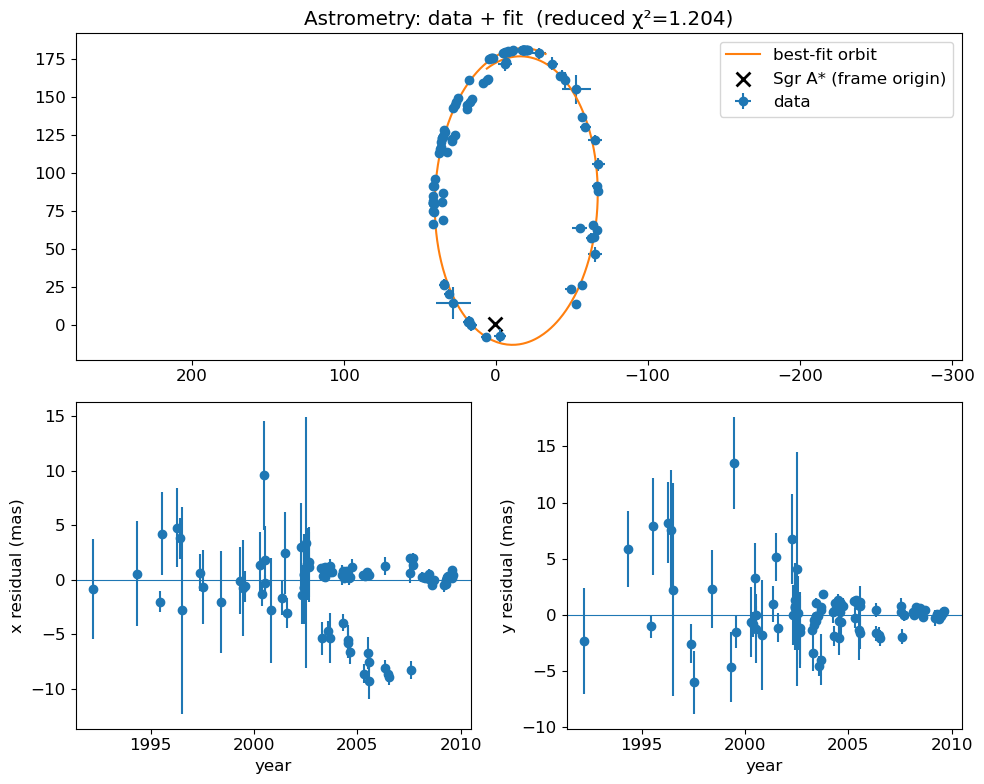

In [11]:
def compute_chi2_and_plots(df, popt):
    """
    Astrometry-only chi^2 + plots.
    popt indices:
      0..6  : a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year
      7     : R0_kpc
      8..11 : x0_mas, y0_mas, vx0_masyr, vy0_masyr
      12    : log_s_xy
    """
    # unpack
    a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year = popt[:7]
    R0_kpc = popt[7]
    x0, y0, vx0, vy0 = popt[8], popt[9], popt[10], popt[11]
    log_s_xy = popt[12]
    s_xy = np.exp(log_s_xy)

    # data
    t = df['year'].values
    xobs = df['x_mas'].values
    yobs = df['y_mas'].values
    xerr = df['x_err_mas'].values
    yerr = df['y_err_mas'].values

    # model
    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )

    # chi^2
    denom_x = np.sqrt(xerr**2 + s_xy**2)
    denom_y = np.sqrt(yerr**2 + s_xy**2)
    chi2_ast = np.sum(((xobs - xmod)/denom_x)**2 + ((yobs - ymod)/denom_y)**2)
    N_ast = 2 * len(t)
    N_params = len(popt)
    dof = N_ast - N_params
    red = chi2_ast / max(dof, 1)

    print(f"Global chi2 = {chi2_ast:.2f}, dof = {dof}, reduced chi2 = {red:.3f}")
    print(f"  Jitter: s_xy = {s_xy:.3f} mas  |  R0 = {R0_kpc:.3f} kpc")

    # -------- Plots --------
    # Orbit on sky
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, fmt='o', label='data')
    t_fine = np.linspace(t.min() - 1, t.max() + 1, 1000)
    xfit, yfit, _, _ = orb_elements_to_sky(
        t_fine, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )
    plt.plot(xfit, yfit, '-', label='best-fit orbit')
    plt.scatter([x0], [y0], marker='x', color='k', s=100, linewidths=2, label='Sgr A* (frame origin)')
    plt.gca().invert_xaxis()
    plt.axis('equal')
    plt.legend()
    plt.title(f'Astrometry: data + fit  (reduced χ²={red:.3f})')

    # Residuals vs time (mas)
    plt.subplot(223)
    plt.errorbar(df['year'], xobs - xmod, yerr=xerr, fmt='o')
    plt.axhline(0, linewidth=0.8)
    plt.xlabel('year'); plt.ylabel('x residual (mas)')

    plt.subplot(224)
    plt.errorbar(df['year'], yobs - ymod, yerr=yerr, fmt='o')
    plt.axhline(0, linewidth=0.8)
    plt.xlabel('year'); plt.ylabel('y residual (mas)')

    plt.tight_layout()
    plt.show()

# call as before:
compute_chi2_and_plots(df, popt)



## Conclusion

Using astrometry data for S2, we fit a full Keplerian orbit with frame offsets, linear drift, and astrometric jitter. Because sky-plane angles do not constrain the physical distance, we applied a Gaussian prior on the Galactic Center distance $(R_0 = 8.0 \pm\ 0.2)$ kpc to regularize the fit. The model converged to $(a = 125.4)$ mas and $(P = 16.13)$ yr, giving a physical semimajor axis of $(1028)$ AU and a black hole mass of $((4.18 \pm\ 0.78)\times10^6\,M_\odot)$, consistent with published values. A full determination of $(R_0)$ and mass of Sgr A* without priors would require incorporating radial velocity data.


## Contribution Statement

Allison Trusko:

- Markdowns
- Astroquerying the S2 orbital data
- Code cleanup
- Debugging
- Fixing $\chi^2_{\rm red}$ to be closer to 1
- README.md file

Eling Cheng:

- Markdowns
- Making the GitHub
- Code cleanup
- Debugging
- requirements.txt file
- README.md file